# Round Trip Tear Sheet Example

When evaluating the performance of an investing strategy, it is helpful to quantify the frequency, duration, and profitability of its independent bets, or "round trip" trades. A round trip trade is started when a new long or short position is opened and then later completely or partially closed out.

The intent of the round trip tearsheet is to help differentiate strategies that profited off a few lucky trades from strategies that profited repeatedly from genuine alpha. Breaking down round trip profitability by traded name and sector can also help inform universe selection and identify exposure risks. For example, even if your equity curve looks robust, if only two securities in your universe of fifteen names contributed to overall profitability, you may have reason to question the logic of your strategy.

To identify round trips, pyfolio reconstructs the complete portfolio based on the transactions that you pass in. When you make a trade, pyfolio checks if shares are already present in your portfolio purchased at a certain price. If there are, we compute the PnL, returns and duration of that round trip trade. In calculating round trips, pyfolio will also append position closing transactions at the last timestamp in the positions data. This closing transaction will cause the PnL from any open positions to realized as completed round trips.

In [2]:
import pyfolio as pf
%matplotlib inline
import gzip
import os
import pandas as pd

# silence warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
transactions = pd.read_csv(gzip.open('../tests/test_data/test_txn.csv.gz'),
                    index_col=0, parse_dates=True)
positions = pd.read_csv(gzip.open('../tests/test_data/test_pos.csv.gz'),
                    index_col=0, parse_dates=True)
returns = pd.read_csv(gzip.open('../tests/test_data/test_returns.csv.gz'),
                      index_col=0, parse_dates=True, header=None)[1]

In [4]:
# Optional: Sector mappings may be passed in as a dict or pd.Series. If a mapping is
# provided, PnL from symbols with mappings will be summed to display profitability by sector.
sect_map = {'COST': 'Consumer Goods', 'INTC':'Technology', 'CERN':'Healthcare', 'GPS':'Technology',
            'MMM': 'Construction', 'DELL': 'Technology', 'AMD':'Technology'}

The easiest way to run the analysis is to call `pyfolio.create_round_trip_tear_sheet()`. Passing in a sector map is optional. You can also pass `round_trips=True` to `pyfolio.create_full_tear_sheet()` to have this be created along all the other analyses.

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,5822.00,1155.00,4667.00
Percent profitable,0.50,0.52,0.49
Winning round_trips,2887.00,596.00,2291.00
Losing round_trips,2917.00,553.00,2364.00
Even round_trips,18.00,6.00,12.00


PnL stats,All trades,Short trades,Long trades
Total profit,$65404.25,$3560.10,$61844.15
Gross profit,$448803.34,$20608.45,$428194.89
Gross loss,$-383399.09,$-17048.35,$-366350.75
Profit factor,$1.17,$1.21,$1.17
Avg. trade net profit,$11.23,$3.08,$13.25
Avg. winning trade,$155.46,$34.58,$186.90
Avg. losing trade,$-131.44,$-30.83,$-154.97
Ratio Avg. Win:Avg. Loss,$1.18,$1.12,$1.21
Largest winning trade,$9500.14,$1623.24,$9500.14
Largest losing trade,$-22902.83,$-661.29,$-22902.83


Duration stats,All trades,Short trades,Long trades
Avg duration,13 days 03:21:49.653555,2 days 10:39:35.064935,15 days 18:53:36.628026
Median duration,8 days 00:00:00,2 days 00:00:00,12 days 00:00:00
Longest duration,84 days 00:00:00,13 days 00:00:00,84 days 00:00:00
Shortest duration,0 days 00:00:01,1 days 00:00:00,0 days 00:00:01


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.01%,0.00%,0.01%
Avg returns winning,0.13%,0.03%,0.15%
Avg returns losing,-0.11%,-0.03%,-0.13%
Median returns all round_trips,-0.00%,0.00%,-0.00%
Median returns winning,0.02%,0.01%,0.03%
Median returns losing,-0.01%,-0.00%,-0.02%
Largest winning trade,6.78%,1.37%,6.78%
Largest losing trade,-17.23%,-0.72%,-17.23%


Symbol stats,AMD,CERN,COST,DELL,GPS,INTC,MMM
Avg returns all round_trips,-0.00%,0.02%,0.02%,-0.03%,0.00%,0.02%,0.01%
Avg returns winning,0.20%,0.15%,0.10%,0.11%,0.10%,0.11%,0.10%
Avg returns losing,-0.19%,-0.13%,-0.07%,-0.15%,-0.09%,-0.06%,-0.09%
Median returns all round_trips,-0.00%,0.00%,0.00%,-0.00%,-0.00%,-0.00%,0.00%
Median returns winning,0.03%,0.02%,0.02%,0.02%,0.02%,0.01%,0.02%
Median returns losing,-0.02%,-0.01%,-0.01%,-0.02%,-0.01%,-0.01%,-0.01%
Largest winning trade,6.78%,6.14%,3.96%,2.78%,1.80%,2.40%,2.45%
Largest losing trade,-17.23%,-3.92%,-2.32%,-6.39%,-6.86%,-4.45%,-1.79%


Profitability (PnL / PnL total) per name,
symbol,
COST,39.90%
INTC,38.27%
CERN,32.31%
MMM,22.15%
GPS,4.94%
AMD,-6.41%
DELL,-31.15%


Profitability (PnL / PnL total) per name,
symbol,
Consumer Goods,39.90%
Healthcare,32.31%
Construction,22.15%
Technology,5.65%


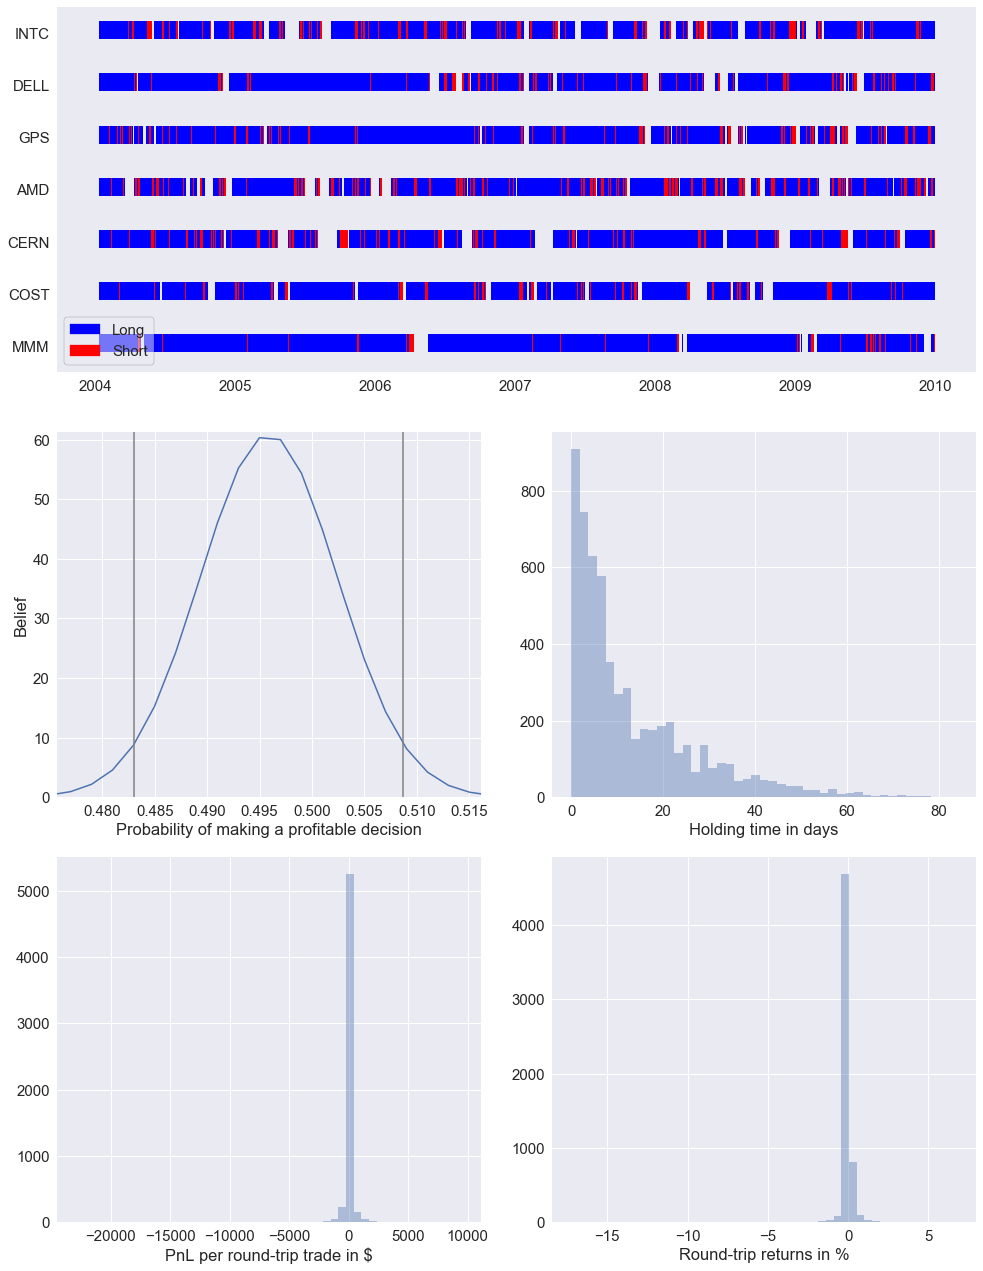

In [5]:
pf.create_round_trip_tear_sheet(returns, positions, transactions, sector_mappings=sect_map)

Under the hood, several functions are being called. `extract_round_trips()` does the portfolio reconstruction and creates the round-trip trades.

In [6]:
rts = pf.round_trips.extract_round_trips(transactions, 
                                         portfolio_value=positions.sum(axis='columns') / (returns + 1))

In [7]:
rts.head()

,close_dt,long,open_dt,pnl,rt_returns,symbol,duration,returns
0,2004-01-13,True,2004-01-09,-126.000000,-0.022523,AMD,4 days,-0.001249
1,2004-01-16,True,2004-01-09,50.020000,0.078507,AMD,7 days,0.000503
2,2004-01-20,True,2004-01-09,1540.099065,0.104696,AMD,11 days,0.015257
3,2004-01-21,False,2004-01-20,287.119806,0.085155,AMD,1 days,0.002861
4,2004-01-22,False,2004-01-20,103.349947,0.112198,AMD,2 days,0.001032


In [8]:
pf.round_trips.print_round_trip_stats(rts)

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,5819.00,1155.00,4664.00
Percent profitable,0.50,0.52,0.49
Winning round_trips,2888.00,596.00,2292.00
Losing round_trips,2914.00,553.00,2361.00
Even round_trips,17.00,6.00,11.00


PnL stats,All trades,Short trades,Long trades
Total profit,$67003.94,$3531.32,$63472.61
Gross profit,$448674.42,$20579.67,$428094.75
Gross loss,$-381670.48,$-17048.35,$-364622.13
Profit factor,$1.18,$1.21,$1.17
Avg. trade net profit,$11.51,$3.06,$13.61
Avg. winning trade,$155.36,$34.53,$186.78
Avg. losing trade,$-130.98,$-30.83,$-154.44
Ratio Avg. Win:Avg. Loss,$1.19,$1.12,$1.21
Largest winning trade,$9500.14,$1623.24,$9500.14
Largest losing trade,$-22902.83,$-661.29,$-22902.83


Duration stats,All trades,Short trades,Long trades
Avg duration,13 days 03:27:07.702354,2 days 10:39:35.064935,15 days 19:02:40.548885
Median duration,8 days 00:00:00,2 days 00:00:00,12 days 00:00:00
Longest duration,84 days 00:00:00,13 days 00:00:00,84 days 00:00:00
Shortest duration,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.01%,0.00%,0.01%
Avg returns winning,0.13%,0.03%,0.15%
Avg returns losing,-0.11%,-0.03%,-0.13%
Median returns all round_trips,-0.00%,0.00%,-0.00%
Median returns winning,0.02%,0.01%,0.03%
Median returns losing,-0.01%,-0.00%,-0.02%
Largest winning trade,6.78%,1.37%,6.78%
Largest losing trade,-17.23%,-0.72%,-17.23%


Symbol stats,AMD,CERN,COST,DELL,GPS,INTC,MMM
Avg returns all round_trips,-0.00%,0.02%,0.02%,-0.03%,0.00%,0.02%,0.01%
Avg returns winning,0.20%,0.15%,0.10%,0.11%,0.10%,0.11%,0.10%
Avg returns losing,-0.19%,-0.13%,-0.07%,-0.15%,-0.09%,-0.06%,-0.09%
Median returns all round_trips,-0.00%,0.00%,0.00%,-0.00%,-0.00%,-0.00%,0.00%
Median returns winning,0.03%,0.02%,0.02%,0.02%,0.02%,0.01%,0.02%
Median returns losing,-0.02%,-0.01%,-0.01%,-0.02%,-0.01%,-0.01%,-0.01%
Largest winning trade,6.78%,6.14%,3.96%,2.78%,1.80%,2.40%,2.45%
Largest losing trade,-17.23%,-3.92%,-2.32%,-6.39%,-6.86%,-4.45%,-1.79%
